In [30]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 
import Metric

import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk




In [31]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)

<module 'ImageAnalysis' from 'c:\\Users\\HP\\Documents\\JHU_Academics\\Research\\PHANGS\\PHANGSDustFill\\ImageAnalysis.py'>

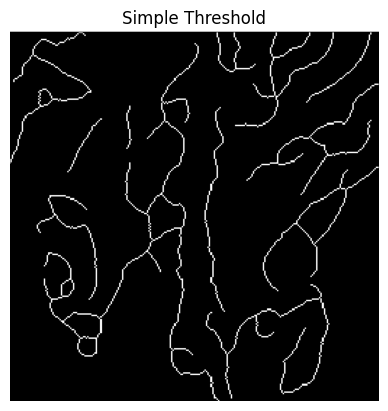

True

In [32]:
input_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1.png'
input_thresh = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InputThresh.png'
# Read the image using OpenCV
input_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale image

# Apply thresholding (assuming grayscale image)

ret,thresh = cv2.threshold(input_img,100,255,cv2.THRESH_BINARY)

# Display the thresholded image (optional)
plt.imshow(thresh, cmap='gray')
plt.axis('off')  # Turn off axes
plt.title('Simple Threshold')
plt.show()

cv2.imwrite(input_thresh, thresh)


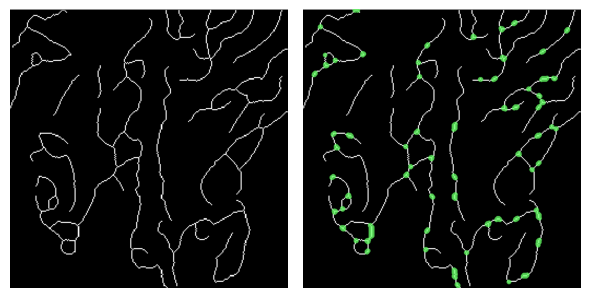

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InputThresh.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png


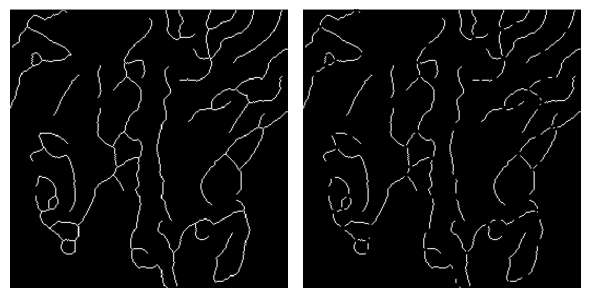

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InputThresh.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png


[(40, 246),
 (41, 242),
 (41, 243),
 (41, 244),
 (41, 245),
 (42, 241),
 (42, 242),
 (42, 243),
 (42, 244),
 (42, 245),
 (43, 240),
 (43, 241),
 (43, 242),
 (43, 243),
 (43, 244),
 (43, 245),
 (44, 239),
 (44, 240),
 (44, 241),
 (44, 242),
 (44, 243),
 (45, 238),
 (45, 239),
 (45, 240),
 (45, 241),
 (45, 242),
 (46, 238),
 (46, 239),
 (46, 240),
 (46, 241),
 (63, 66),
 (63, 67),
 (64, 65),
 (64, 66),
 (64, 67),
 (65, 65),
 (65, 66),
 (65, 67),
 (66, 65),
 (66, 66),
 (66, 67),
 (82, 171),
 (82, 172),
 (83, 206),
 (83, 207),
 (83, 208),
 (83, 209),
 (83, 210),
 (83, 211),
 (83, 212),
 (84, 206),
 (84, 207),
 (84, 208),
 (84, 209),
 (84, 210),
 (84, 211),
 (84, 212),
 (84, 213),
 (85, 207),
 (85, 208),
 (85, 209),
 (85, 210),
 (85, 211),
 (85, 212),
 (85, 213),
 (86, 207),
 (86, 208),
 (86, 209),
 (86, 210),
 (86, 211),
 (86, 212),
 (87, 209),
 (87, 210),
 (87, 211),
 (87, 212),
 (88, 210),
 (88, 211),
 (88, 212),
 (89, 210),
 (89, 211),
 (89, 212),
 (90, 210),
 (90, 211),
 (107, 628),
 (

In [33]:
input_image = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1.png'
intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png'
 
#IMF.invert_image(input_image, invert_input)
IA.identify_intersects(input_thresh, intersects_removed, dot_size=8,box_size=121, perc = .4, RGBA_color = (100, 255, 100, 200), title = 'Processed Image with Intersects in green')
IA.identify_intersects(input_thresh, intersects_removed, dot_size=4,box_size=121, perc = .4, RGBA_color = (0, 0, 0, 255), title = 'Processed Image with Intersects Removed') 

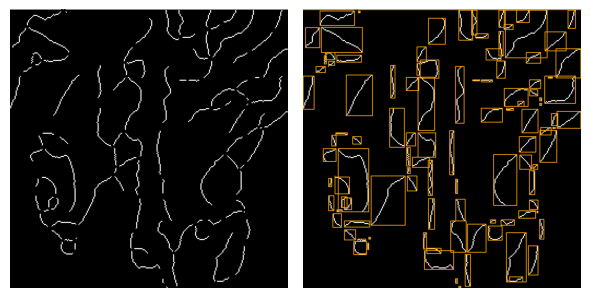

In [34]:
labels, stats, num_labels = IA.identify_connected_components(intersects_removed)

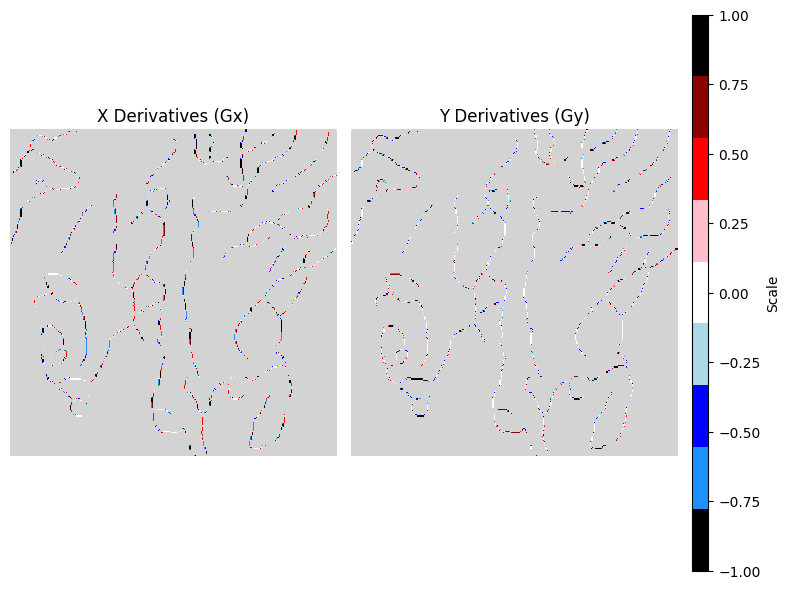

In [35]:
# read the image
importlib.reload(IA)
importlib.reload(PF)

mask_path = intersects_removed

sobel_x, sobel_y = IA.apply_sobel_filter_to_components(intersects_removed, labels, stats, num_labels)
PF.plot_sobel_derivatives(mask_path,sobel_x, sobel_y)



c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:101: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:101: RuntimeWarning: invalid value encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:85: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


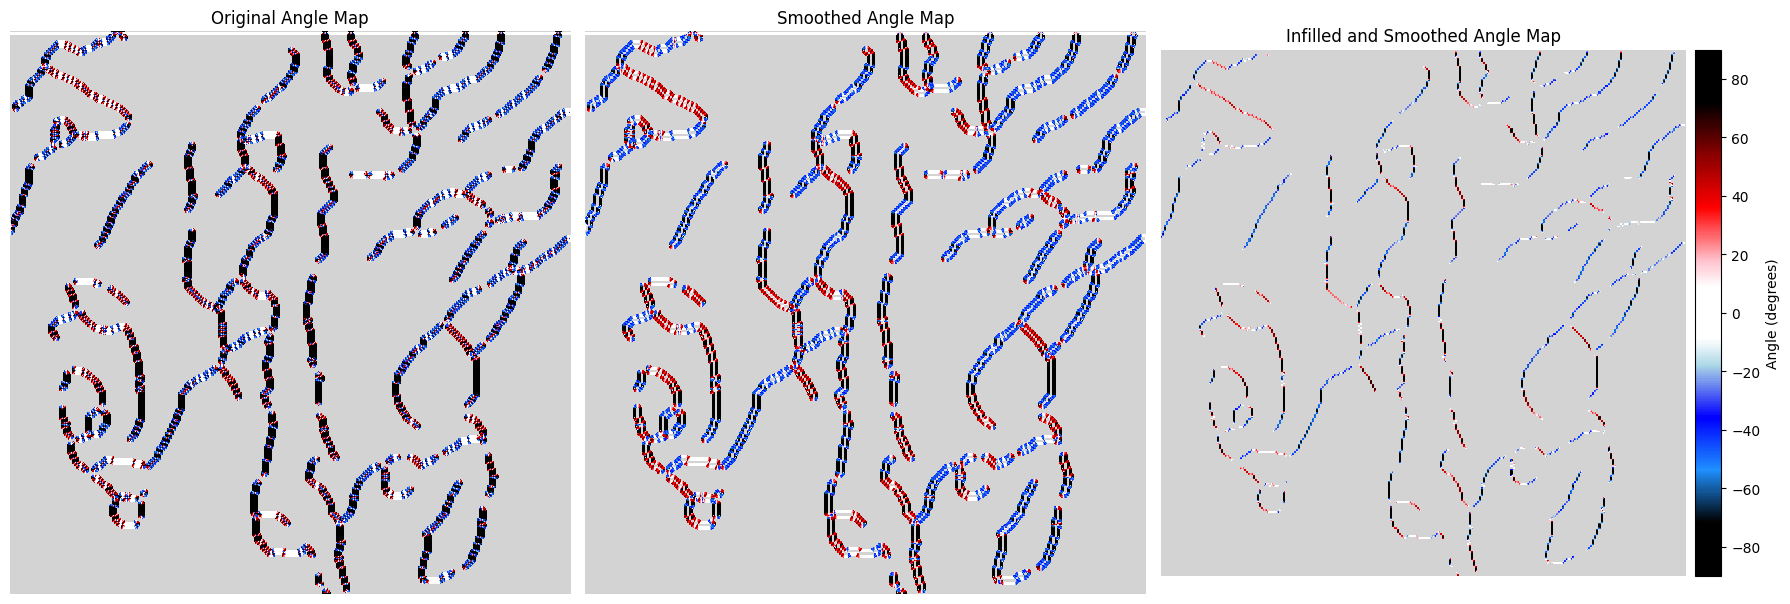

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [36]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
smoothed_angle_map, copy_angled_map = PF.plot_arctan_with_smoothing(sobel_y, sobel_x,intersects_removed, 3, smoothed_angles)

Number of hexagons: 56


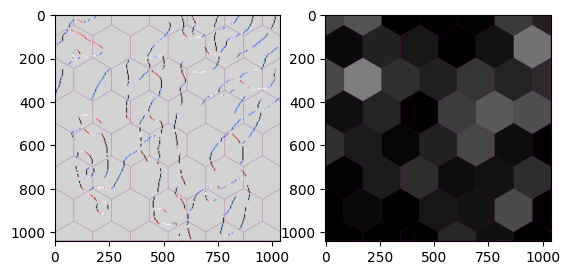

In [37]:
import csv

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)

# Paths and image loading
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
img = cv2.imread(original_image_path, cv2.COLOR_BGR2RGB)

# Hexagon settings
hexagon_size = 100
hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(original_image_path, hexagon_size)
hexagon_centers = [x[0] for x in hexagons]
hexagon_corners = [x[1] for x in hexagons]

hex_dict = {}

# Process each hexagon
for i in range(len(hexagon_corners)):
    mask = myGUI.get_hexagon_mask(img.shape, hexagon_corners[i])
    data_in_hexagon = smoothed_angle_map[mask == 255]
    data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]
    if len(data_in_hexagon) > 300 and np.mean(data_in_hexagon) != 0:
        hex_dict[hexagon_centers[i]] = (Metric.alignment_metric(data_in_hexagon), len(data_in_hexagon))
    else:
        hex_dict[hexagon_centers[i]] = (np.nan, np.nan)
print(f'Number of hexagons: {len(hexagon_centers)}')

# Create a new image to draw the hexagons filled with the alignment metric colors
hexagon_image = Image.new("RGB", (img.shape[1], img.shape[0]))
draw = ImageDraw.Draw(hexagon_image)

count = 0

# Save hex_dict to CSV
csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thinSkeletonData.csv'
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Hexagon Center', 'Number of Pixels', 'Alignment Metric'])
    for center, info in hex_dict.items():
        metric = info[0]
        number_of_pixels = info[1]
        writer.writerow([center, number_of_pixels, metric])
        if not np.isnan(metric):
            grayscale_value = int(metric**2 * 255)  # Map to grayscale (0 to 255)
            corners = hexagon_corners[count]
            draw.polygon(corners, fill=(grayscale_value, grayscale_value, grayscale_value), outline="purple")
        else:
            corners = hexagon_corners[count]
            draw.polygon(corners, fill=(0, 0, 0), outline="purple")
        count += 1

# Display the original and processed images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(hexagon_image_og)
ax[1].imshow(hexagon_image)
plt.show()

In [38]:
importlib.reload(myGUI)
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
csv_path = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thinskeletondata.csv"
data_array = smoothed_angle_map
myGUI.run_hexagon_analysis(original_image_path, csv_path, data_array)